In [77]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import tdt
import trompy as tp

import dill

from extract_behav_parameters import get_ttls, read_DLC_csv, interpolate_low_likehood, calc_angular_velocity, calc_stillness, calc_bodypart_movement

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
DATAFOLDER = Path("..//data")
TANKFOLDER = Path("D://TestData//bazzino//from_paula")
DLCFOLDER = TANKFOLDER / "Sodium_Appetite_DLC" #office computer
DLCFOLDER = Path("C:/Users/jmc010/Data/bazzino/Output DLC shuffle 4 csv files") # laptop

In [78]:
stub = "PB71-221123-113609"
# get_ttls(stub, DATAFOLDER, TANKFOLDER)
dlcdata = read_DLC_csv(stub, DLCFOLDER)
df = interpolate_low_likehood(dlcdata, threshold=0.6)
# df = calc_angular_velocity(df, rightear="r_ear", leftear="l_ear")

movement = calc_bodypart_movement(df)

Found file: C:\Users\jmc010\Data\bazzino\Output DLC shuffle 4 csv files\PB_NAapp-221123_PB71-221123-113609_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv


In [79]:
movement

0             NaN
1        0.188075
2        0.087142
3        0.476965
4        0.037926
           ...   
26304    0.183199
26305    0.071509
26306    0.892300
26307    1.000000
26308    0.173580
Length: 26309, dtype: float64

In [ ]:
# Functions for notebook - may remove into src

def get_angular_velocity(stub, dlcfolder):
    
    df = read_DLC_csv(stub, dlcfolder)
    
    df = interpolate_low_likehood(df, threshold=0.5)

    df = calc_angular_velocity(df)
    
    return df.d_angle_deg

def get_ang_vel_snips(stub):
    # Get the angular velocity snips
    
    sol = get_ttls(stub)
    v = get_angular_velocity(stub)
    
    snips_vel = []
    for i in range(len(sol)-1):
        start = int(sol[i] * 10) - 50
        end = int(sol[i] * 10) + 150
        snips_vel.append(v[start:end])
        
    snips_vel = np.array(snips_vel)
    
    # snips_vel = tp.zscore(snips_vel, baseline_points=50)
    
    return np.array(snips_vel)

## For testing purposes
# stub = "PB71-221123-113609"
# get_ttls(stub)
# snips_vel = get_ang_vel_snips(stub)    

In [ ]:
def get_stillness(stub, dlcfolder):
    
    df = read_DLC_csv(stub, dlcfolder)
    
    df = interpolate_low_likehood(df, threshold=0.5)

    df = calc_stillness(df)
    
    return df.stillness_z

def get_stillness_snips(stub):
    # Get the angular velocity snips
    
    sol = get_ttls(stub)
    v = get_stillness(stub)
    
    snips_still = []
    for i in range(len(sol)-1):
        start = int(sol[i] * 10) - 50
        end = int(sol[i] * 10) + 150
        snips_still.append(v[start:end])
        
    snips_still = np.array(snips_still)
    
    # snips_vel = tp.zscore(snips_vel, baseline_points=50)
    
    return np.array(snips_still)

## For testing purposes
# stub = "PB71-221123-113609"
# stub = "PB48-220926-121542" #0.45, deplete
# stub = "PB73-221123-131413" #0.45, deplete
# stub = "PB75-221123-140659" #0.45, deplete
# stub = "PB61-221024-110730" #0.10, deplete

snips = get_stillness_snips(stub)

In [113]:
def get_movement(stub, dlcfolder):
    
    df = read_DLC_csv(stub, dlcfolder)
    
    df = interpolate_low_likehood(df, threshold=0.6)

    movement = calc_bodypart_movement(df, weight_by_zscore=True)
    
    return movement

def get_movement_snips(stub):
    # Get the angular velocity snips
    
    sol = get_ttls(stub, DATAFOLDER, TANKFOLDER)
    v = get_movement(stub, DLCFOLDER)
    
    snips_move = []
    for i in range(len(sol)-1):
        start = int(sol[i] * 10) - 50
        end = int(sol[i] * 10) + 150
        snips_move.append(v[start:end])
        
    snips_move = np.array(snips_move)
    
    # snips_move = tp.zscore(snips_move, baseline_points=50)
    
    return snips_move

## For testing purposes
stub = "PB71-221123-113609"
stub = "PB48-220926-121542" #0.45, deplete
# stub = "PB73-221123-131413" #0.45, deplete
# stub = "PB75-221123-140659" #0.45, deplete
stub = "PB61-221024-110730" #0.10, deplete

snips = get_movement_snips(stub)

Found file: C:\Users\jmc010\Data\bazzino\Output DLC shuffle 4 csv files\PB_NAapp-221024_PB61-221024-110730_Cam1DLC_Resnet50_bazzino-dlcNov9shuffle4_snapshot_best-200.csv


<Axes: >

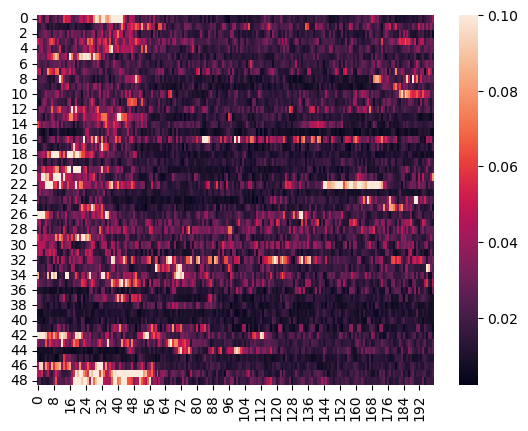

In [114]:
sns.heatmap(snips,
            vmax=0.1
            )

In [21]:
# also make accompanying df that contains details of the rat and the condition and the time in session

def assemble_all_data(csv_path, tank_folder, dlc_folder, snips_function=get_ang_vel_snips):
    metadata = pd.read_csv(csv_path)
    
    snips_array = []
    x_array = []
    
    for row in metadata.iterrows():
        stub = row[1]["Folder"]
        
        print(stub)
        try:
            
            snips_tmp = snips_function(stub)
            nsnips = len(snips_tmp)
            print(nsnips)
            snips_array.append(snips_tmp)
            
            x_array.append(pd.DataFrame(data={"trial": np.arange(nsnips),
                                              "id": row[1]["Subject"],
                                              "condition": row[1]["Physiological state"]
                                             }
                                       )
                          )           
        except:
            print("Error with tank for", row[1]["Subject"], row[1]['Physiological state'])
        
    return snips_array, x_array

snips_10NaCl, x_10NaCl = assemble_all_data(DATAFOLDER / "10NaCl_FileKey.csv", TANKFOLDER, DLCFOLDER, snips_function=get_ang_vel_snips)
snips_45NaCl, x_45NaCl = assemble_all_data(DATAFOLDER / "45NaCl_FileKey.csv", TANKFOLDER, DLCFOLDER, snips_function=get_ang_vel_snips)

snips_10NaCl = np.concatenate(snips_10NaCl, axis=0)
snips_45NaCl = np.concatenate(snips_45NaCl, axis=0)

snips_vel = np.vstack((snips_10NaCl, snips_45NaCl))
snips_vel.shape

snips_10NaCl, x_10NaCl = assemble_all_data(DATAFOLDER / "10NaCl_FileKey.csv", TANKFOLDER, DLCFOLDER, snips_function=get_stillness_snips)
snips_45NaCl, x_45NaCl = assemble_all_data(DATAFOLDER / "45NaCl_FileKey.csv", TANKFOLDER, DLCFOLDER, snips_function=get_stillness_snips)

snips_10NaCl = np.concatenate(snips_10NaCl, axis=0)
snips_45NaCl = np.concatenate(snips_45NaCl, axis=0)

snips_still = np.vstack((snips_10NaCl, snips_45NaCl))
snips_still.shape


PB23-220608-131619
Found file: D:\TestData\bazzino\from_paula\Sodium_Appetite_DLC\PB_NAapp-220608_PB23-220608-131619_Cam1DLC_resnet50_Raw_VideosMar27shuffle1_50000.csv
49
PB24-220608-122638
Found file: D:\TestData\bazzino\from_paula\Sodium_Appetite_DLC\PB_NAapp-220608_PB24-220608-122638_Cam1DLC_resnet50_Raw_VideosMar27shuffle1_50000.csv
49
PB33-220620-115414
Found file: D:\TestData\bazzino\from_paula\Sodium_Appetite_DLC\PB_NAapp-220620_PB33-220620-115414_Cam1DLC_resnet50_Raw_VideosMar27shuffle1_50000.csv
49
PB39-220629-105034
Found file: D:\TestData\bazzino\from_paula\Sodium_Appetite_DLC\PB_NAapp-220629_PB39-220629-105034_Cam1DLC_resnet50_Raw_VideosMar27shuffle1_50000.csv
49
PB391-220829-111452
Found file: D:\TestData\bazzino\from_paula\Sodium_Appetite_DLC\PB_NAapp-220829_PB391-220829-111452_Cam1DLC_resnet50_Raw_VideosMar27shuffle1_50000.csv
49
PB44-220829-121005
Found file: D:\TestData\bazzino\from_paula\Sodium_Appetite_DLC\PB_NAapp-220829_PB44-220829-121005_Cam1DLC_resnet50_Raw_Video

(2401, 200)

In [22]:
# renames columns and combines dataframes from both infusion types

def tweak_x_array(x_array):

    df = pd.concat(x_array, axis=0)

    return (df
            .replace({"condition": {"Sodium Depleted": "deplete",
                                    "Sodium Replete": "replete",
                                    "Sodium Replete Experienced": "replete_exp",
                                    "Thirsty": "thirsty",                                    
                                    }})
            )

x_10NaCl = tweak_x_array(x_10NaCl)
x_45NaCl = tweak_x_array(x_45NaCl)

x_vel_10NaCl = x_10NaCl.assign(infusiontype="10NaCl")
x_vel_45NaCl = x_45NaCl.assign(infusiontype="45NaCl")

x_vel = pd.concat([x_vel_10NaCl, x_vel_45NaCl]).reset_index(drop=True)

In [23]:
x_vel.shape

(2401, 4)

In [24]:
# code to only select the conditions we want - deplete and replete

snips_vel = snips_vel[(x_vel.condition != "thirsty") & (x_vel.condition != "replete_exp")]
snips_still = snips_still[(x_vel.condition != "thirsty") & (x_vel.condition != "replete_exp")]
x_vel = x_vel.query("condition != 'thirsty' & condition != 'replete_exp'")

In [25]:
# combines with data from subjects csv to get add sex

subjects_10NaCl = pd.read_csv(DATAFOLDER / "10NaCl_SubjectKey.csv")
subjects_45NaCl = pd.read_csv(DATAFOLDER / "45NaCl_SubjectKey.csv")

subject_df = (pd.concat([subjects_10NaCl.iloc[:, :2], subjects_45NaCl.iloc[:, :2]], axis=0)
              .reset_index()
              .rename(columns={"Subject": "id",
                               "Sex": "sex"})
              .drop(columns=["index"])
)

x_vel = pd.merge(x_vel, subject_df[['id', 'sex']], on='id', how='left')

In [26]:
## pre-processing of the DLC angvel snips

# interpolation
df_snips_vel = pd.DataFrame(snips_vel)


df_interpolated = df_snips_vel.interpolate(method='linear', axis=1)
df_filled = df_interpolated.ffill(axis=1).bfill(axis=1)

snips_vel_processed = df_filled.to_numpy()

# find absolute
snips_vel_processed = np.abs(snips_vel_processed)

# how about instead of zscoring, we just adjust to baseline subtraction
baseline = np.nanmean(snips_vel_processed[:, :50], axis=1)
snips_vel_processed = snips_vel_processed - baseline[:, None]

print(np.sum(np.isnan(snips_vel_processed)))
snips_vel = np.array(snips_vel_processed)

# removing NaNs
rows_with_nans_mask = np.isnan(snips_vel).any(axis=1)
snips_vel = snips_vel[~rows_with_nans_mask]
x_vel = x_vel[~rows_with_nans_mask].reset_index(drop=True)
print(snips_vel.shape)
x_vel.shape

0
(1960, 200)


(1960, 5)

In [27]:
def smooth_array(arr, window_size=5):
    """
    Smooth a 2D array along one dimension using a moving average.
    
    :param arr: 2D NumPy array
    :param window_size: Size of the smoothing window
    :return: Smoothed 2D array
    """
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)
    return smoothed

# Example usage
snips_vel = smooth_array(snips_vel, window_size=5)

In [28]:
## pre-processing of the DLC stillness snips

# interpolation
# df_snips_vel = pd.DataFrame(snips_vel)

# df_interpolated = df_snips_vel.interpolate(method='linear', axis=1)
# df_filled = df_interpolated.ffill(axis=1).bfill(axis=1)

# snips_vel_processed = df_filled.to_numpy()

# find absolute
# snips_vel_processed = np.abs(snips_vel_processed)

# how about instead of zscoring, we just adjust to baseline subtraction
# baseline = np.nanmean(snips_still[:, :50], axis=1)
# snips_still = snips_still - baseline[:, None]

# print(np.sum(np.isnan(snips_still)))
# snips_vel = np.array(snips_still)

# removing NaNs
# rows_with_nans_mask = np.isnan(snips_vel).any(axis=1)
# snips_vel = snips_vel[~rows_with_nans_mask]
# x_vel = x_vel[~rows_with_nans_mask].reset_index(drop=True)
# print(snips_vel.shape)
# x_vel.shape

In [29]:
data_to_save = {"snips_vel": snips_vel,
                "snips_still": snips_still,
                "x_vel": x_vel,
                }

with open(DATAFOLDER / "behav_data.pickle", "wb") as f:
    dill.dump(data_to_save, f)

In [ ]:
# with open(DATAFOLDER / "x_angvel.pickle", "wb") as f:
#     dill.dump(x_vel, f)

In [ ]:
# snips_vel_all = np.vstack([snips_10NaCl_selected, snips_45NaCl_selected])

# with open(DATAFOLDER / "snips_angvel.pickle", "wb") as f:
#     dill.dump(snips_vel_all, f)